In [ ]:
# !unzip /content/drive/MyDrive/gender_dataset_face-20220319T023558Z-001.zip -d /content/drive/MyDrive/gender_dataset_face

In [ ]:
import os
os.makedirs("Model_weights", exist_ok=True)


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten

from keras.layers import Dropout
from keras.layers import Dense
from tensorflow.keras import datasets, layers, models
from keras import backend as K
from keras import models
from keras.applications.vgg16 import VGG16


In [ ]:
class SmallerVGGNet:
    @staticmethod
    def vgg_net(width, height, depth, classes):

            conv_base = VGG16(weights='imagenet',
                          include_top=False,
                          input_shape=(height, width, depth))
            model = models.Sequential()

            model.add(conv_base)
            model.add(Flatten())

            model.add(Dense(1024, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(classes, activation='sigmoid'))
            return model

In [ ]:
import matplotlib
matplotlib.use("Agg")  # Only needed in headless environments like servers
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import img_to_array, to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# If you have a custom model, make sure the import is correct
# from model.smallervggnet import SmallerVGGNet  # Uncomment if you have this file and model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()

        # First CONV => RELU => POOL layer
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(height, width, depth)))
        model.add(MaxPooling2D(pool_size=(3, 3)))

        # Second CONV => RELU => POOL layer
        model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Third CONV => RELU => POOL layer
        model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Flatten and add Fully Connected layers
        model.add(Flatten())
        model.add(Dense(256, activation="relu"))
        model.add(Dropout(0.5))  # Prevent overfitting
        model.add(Dense(classes, activation="softmax"))  # Output layer

        return model

model = SmallerVGGNet.build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=2)




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import glob
import os
import random
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
#from SmallerVGGNet import SmallerVGGNet

epochs = 50
lr = 1e-3
batch_size = 32
img_dims = (96, 96, 3)

data = []
labels = []

# Load image files
image_files = [f for f in glob.glob('/content/drive/MyDrive/ARCHIVE/gender_dataset_face' + "/**/*", recursive=True)
               if not os.path.isdir(f)]
random.seed(42)
random.shuffle(image_files)

# Debug: Check if images are found
if len(image_files) == 0:
    raise ValueError("No images found! Check dataset path.")

# Process images
for img in image_files:
    image = cv2.imread(img)
    if image is None:
        print(f"Skipping unreadable image: {img}")
        continue  # Skip corrupted images

    image = cv2.resize(image, (96, 96))
    image = img_to_array(image)
    data.append(image)

    label = os.path.basename(os.path.dirname(img))  # Extract folder name
    label = 1 if label.lower() == "woman" else 0
    labels.append([label])

# Check dataset size before splitting
if len(data) == 0:
    raise ValueError("No valid images loaded! Check dataset.")

# Preprocessing
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

# Train-test split
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, random_state=2)
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

# Data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# Build and compile model
model = SmallerVGGNet.build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=2)
opt = Adam(learning_rate=lr, decay=lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Model checkpoint
filepath = "epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.keras"  # Use .keras instead of .hdf5
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
callbacks_list = [checkpoint]


# Train model
history = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                    validation_data=(testX, testY),
                    steps_per_epoch=len(trainX) // batch_size,
                    epochs=epochs, verbose=1, callbacks=callbacks_list)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5576 - loss: 0.6923
Epoch 1: val_accuracy improved from -inf to 0.74831, saving model to epochs:001-val_accuracy:0.748.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.5582 - loss: 0.6920 - val_accuracy: 0.7483 - val_loss: 0.5457
Epoch 2/50
 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8125 - loss: 0.5345
Epoch 2: val_accuracy did not improve from 0.74831
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.5345 - val_accuracy: 0.7104 - val_loss: 0.5609
Epoch 3/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7157 - loss: 0.5623
Epoch 3: val_accuracy improved from 0.74831 to 0.84574, saving model to epochs:003-val_accuracy:0.846.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.7158 - loss: 0.5621 - val_accuracy: 0.8457 - val_loss: 0.4025
Epoch 4/50
 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6875 - loss: 0.5384
Epoch 4: val_accuracy did not improve from 0.84574
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.5384 - val_accuracy: 0.8322 - val_loss: 0.4186
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7803 - loss: 0.4730
Epoch 5: val_accuracy improved from 0.84574 to 0.85386, saving model to epochs:005-val_accuracy:0.854.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.7805 - loss: 0.4728 - val_accuracy: 0.8539 - val_loss: 0.3571
Epoch 6/50
 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.2265
Epoch 6: val_accuracy did not improve from 0.85386
92/92 

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')   if drive is not mounteded

In [ ]:
import matplotlib.pyplot as plt

# Ensure training history exists before plotting
if history and hasattr(history, 'history'):
    # Check available keys
    keys = history.history.keys()

    # Determine correct accuracy keys
    acc_key = 'accuracy' if 'accuracy' in keys else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in keys else 'val_acc'
    loss_key = 'loss'
    val_loss_key = 'val_loss'

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[acc_key], label='Train Accuracy')
    plt.plot(history.history[val_acc_key], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[loss_key], label='Train Loss')
    plt.plot(history.history[val_loss_key], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Optional: Save the plots
    plt.savefig('/content/drive/MyDrive/ARCHIVE/result.png')

else:
    print("Error: Training history is empty or model training was not completed.")


from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(testX)
pred = np.argmax(pred,axis = 1)
y_true = np.argmax(testY,axis = 1)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


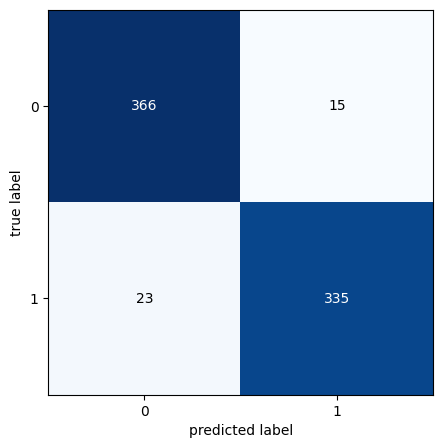

In [ ]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
# plt.show()
fig

In [ ]:
!pip install cvlib

In [ ]:
# from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array

from keras.models import load_model
# from keras.utils import get_file
import numpy as np
import argparse
import cv2
import os
!pip install cvlib
import cvlib as cv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img= '/content/drive/MyDrive/ARCHIVE/man1.jpg'
image = cv2.imread(img)
# cv2.imread('/conte')


In [ ]:
image = cv2.imread('/content/drive/MyDrive/ARCHIVE/women2.jpeg')  #give any image from computer

if image is None:
    print("Could not read input image")
    exit()

# load pre-trained model
model = load_model("/content/drive/MyDrive/ARCHIVE/epochs_049-val_accuracy_0.950.keras")   # check most accuracy and loss and give path of file

# detect faces in the image
face, confidence = cv.detect_face(image)

classes = ['man','woman']
# loop through detected faces
for idx, f in enumerate(face):

     # get corner points of face rectangle
    (startX, startY) = f[0], f[1]
    (endX, endY) = f[2], f[3]

    # draw rectangle over face
    cv2.rectangle(image, (startX,startY), (endX,endY), (0,255,0), 2)

    # crop the detected face region
    face_crop = np.copy(image[startY:endY,startX:endX])

    # preprocessing for gender detection model
    face_crop = cv2.resize(face_crop,(96,96))
    face_crop = face_crop.astype("float") / 255.0
    face_crop = img_to_array(face_crop)
    face_crop = np.expand_dims(face_crop, axis=0)

    # apply gender detection on face
    conf = model.predict(face_crop)[0]
    print(conf)
    print(classes)

    # get label with max accuracy
    idx = np.argmax(conf)
    label = classes[idx]

    label = "{}: {:.2f}%".format(label, conf[idx] * 100)

    Y = startY - 10 if startY - 10 > 10 else startY + 10

    # write label and confidence above face rectangle
    if conf[idx] * 100 > 50.0:
        cv2.putText(image, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
                0.7, (0, 255, 0), 1)
# cv2.imwrite('/content/',image)
# display output
# cv2.imshow("gender detection", image)

# # press any key to close window
# cv2.waitKey(0)

# # save output
cv2.imwrite("gender_detection.jpg", image)

# # release resources
# cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
[2.3005035e-07 9.9999976e-01]
['man', 'woman']


True

Thank you...